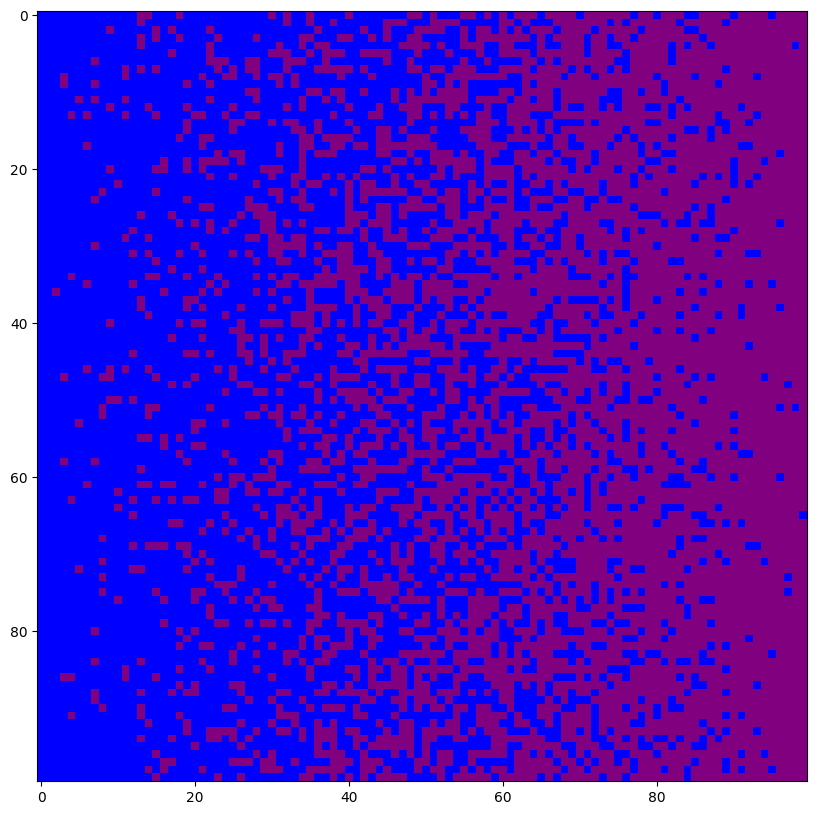

In [29]:
from main import LearningModel

#Here you can run a model once with different learning models and food environments. 
#You can either use 'TD' or 'RW' at learning_model.
#You can pick 'random', 'gradient_l' or 'gradient_h' as food environments.
#You can also fill in an integer (e.g., 1) after seed to make the simulation reproducible.

m = LearningModel(N=100, width=100, height=100, learning_model='RW', distribute_patches = 'gradient_l', seed = None)

for i in range(100):
    m.step()

df = m.datacollector.get_agent_vars_dataframe()
df1 = df.reset_index()

m.visualize() #In case you want to check distribution of food on map.

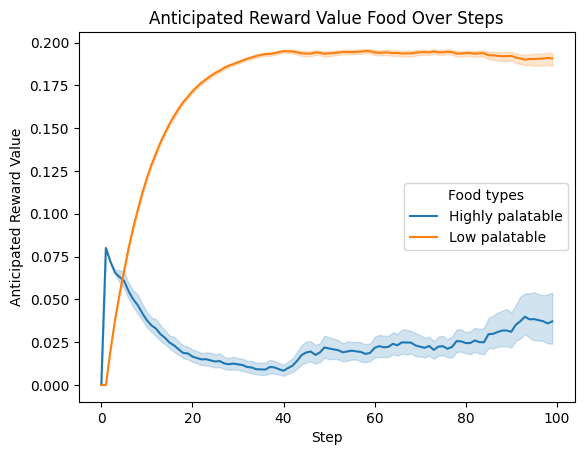

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

#Plot the results of the single run.

sns.lineplot(df1, x = "Step", y = "Value_High", label = "Highly palatable")
sns.lineplot(df1, x = "Step", y = "Value_Low", label = "Low palatable")
plt.title('Anticipated Reward Value Food Over Steps')
plt.ylabel('Anticipated Reward Value')
plt.legend(title = 'Food types')

In [45]:
from tqdm import tqdm 
import pandas as pd

learning_models = ["RW", "TD"]
distribute_patches = ["random", "gradient_h", "gradient_l"]

def batch_run():
    results = []

    for learning_model in learning_models:
        for distribute_patch in distribute_patches:
            for i in tqdm(range(100), desc = f"Running {learning_model} with {distribute_patch}"):
                model = LearningModel(N=100, width = 100, height = 100, learning_model=learning_model, distribute_patches=distribute_patch)

                for step in range(100):
                    model.step()

                for agent in model.schedule.agents:
                    results.append({
                        "Run": i,
                        "LearningModel": learning_model,
                        "Distribute_Patches": distribute_patch,
                        "Agent_ID": agent.unique_id,
                        "Value_High": agent.value_high,
                        "Value_Low": agent.value_low
                    })

    return results

results = batch_run()

data = pd.DataFrame(results)

Running TD with gradient_l: 100%|██████████| 100/100 [00:21<00:00,  4.58it/s]


In [43]:
print(data)

       Run  Step LearningModel Distribute_Patches  Value_High  Value_Low
0        0    99            RW             random    0.546350   0.063407
1        0    99            RW             random    0.473489   0.081623
2        0    99            RW             random    0.710093   0.022472
3        0    99            RW             random    0.564472   0.058877
4        0    99            RW             random    0.314593   0.121346
...    ...   ...           ...                ...         ...        ...
59995   99    99            TD         gradient_l    0.080000   0.199994
59996   99    99            TD         gradient_l    0.548952   0.199983
59997   99    99            TD         gradient_l    0.796660   0.198727
59998   99    99            TD         gradient_l    0.596651   0.199979
59999   99    99            TD         gradient_l    0.792242   0.199452

[60000 rows x 6 columns]
